## LSN theoratical toy example
### Quadratic brain ROI trajectories with age

### 1. Additive initial factor: subject variability
### 2. Additive time shift: ROI variability


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
                    


In [2]:
def get_brain_trajectory(n_timepoints, intercept, time_shift, poly_order):
    """ Generates ROI values over time based on a given polynomial model
    """
    t = np.arange(n_timepoints)
    traj = intercept - ( (t-time_shift)**poly_order ) / (time_shift**poly_order)
    return traj

def get_traj_samples(traj, n_samples, criterion="intercept"):
    """ Generates N trajectory samples by adding random factor
    """
    random_factor = np.random.randn(n_samples)
    traj_sample = []
    for i in np.arange(n_samples):
        if criterion == "intercept":
            traj_sample.append(random_factor[i] + traj)
        else:
            print("to be implemented")

    return np.array(traj_sample)

def get_cross_sectional_samples(roi_list, followup_interval=0):
    """ Samples one timepoint per sample with replacement
    """
    n_samples, n_timepoints = roi_list[0].shape
    t = np.arange(n_timepoints-followup_interval)

    # sample only once and apply to all ROIs
    age_samples = np.random.choice(t,n_samples,replace=True)
    roi_sample_idx = list(zip(np.arange(n_samples), age_samples))

    roi_sampled_list = []
    for roi in roi_list:
        roi_sampled_list.append(roi[tuple(np.transpose(roi_sample_idx))])

    roi_sampled_array = np.vstack(roi_sampled_list).T

    # Followup visits --> same subjects and time-shifted ROI values
    followup_roi_sampled_array = None
    if followup_interval > 0:
        followup_roi_sampled_list = []
        followup_roi_sample_idx = list(zip(np.arange(n_samples), age_samples + followup_interval))
        for roi in roi_list:
            followup_roi_sampled_list.append(roi[tuple(np.transpose(roi_sample_idx))])

        followup_roi_sampled_array = np.vstack(followup_roi_sampled_list).T

    return age_samples, roi_sampled_array, followup_roi_sampled_array

## Brain trajectories
### ROI variability: Additive time shift: ROI variability

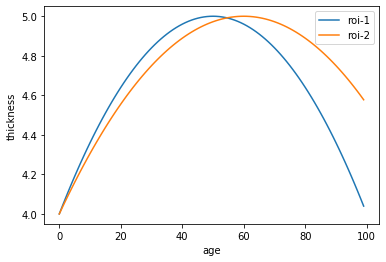

In [3]:
n_timepoints = 100
intercept = 5
poly_order = 2

traj1_time_shift = 50
traj2_time_shift = 60

traj1 = get_brain_trajectory(n_timepoints,intercept,traj1_time_shift,poly_order)
traj2 = get_brain_trajectory(n_timepoints,intercept,traj2_time_shift,poly_order)

t = np.arange(n_timepoints)
plt.plot(t,traj1, label="roi-1")
plt.plot(t,traj2, label="roi-2")
plt.xlabel("age")
plt.ylabel("thickness")
plt.legend()

## Generate subject-specific random samples 
### Additive initial factor: subject variability

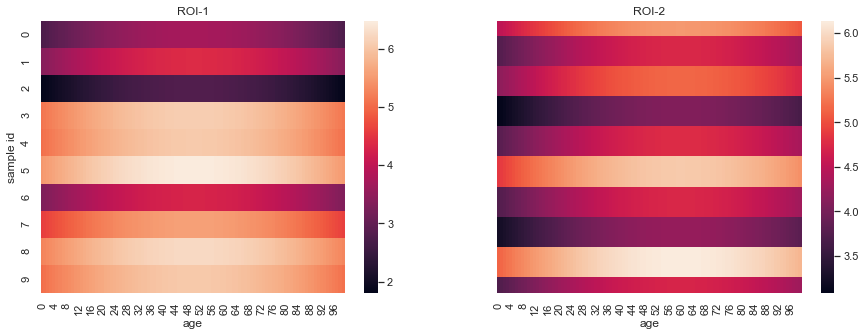

In [75]:
# same init factor for each ROI
n_samples = 10

roi_1 = get_traj_samples(traj1, n_samples)
roi_2 = get_traj_samples(traj2, n_samples)

palette = 'husl'
sns.set(font_scale=1)

fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(roi_1, ax=ax)
    g.set_xlabel("age")
    g.set_ylabel("sample id")
    g.set_title("ROI-1")
    ax = axes[1]
    g = sns.heatmap(roi_2, ax=ax)
    g.set_title("ROI-2")
    g.set_xlabel("age")

## Run entire toy example

In [22]:
def get_brain_age_perf(X,y,model,cv=5):
    """ Compute CV score and heldout sample MAE and correlation
    """
    pipeline = Pipeline([("brainage_model", model)])
    pipeline.fit(X, y)

    # Evaluate the models using crossvalidation
    CV_scores = cross_val_score(pipeline, X, y,
                                scoring="neg_mean_squared_error", cv=cv)

    ## predict on held out test
    y_pred = pipeline.predict(X_test)
    test_MAE = np.mean(abs(y_test - y_pred))
    test_r = stats.pearsonr(y_test,y_pred)[0]

    return CV_scores, test_MAE, test_r


## Torch 

# dataset
class SimDataset(Dataset):
    ''' Simulation dataset
    '''
    def __init__(self, X1, X2, y1, y2, transform=None):
        self.X1 = X1        
        self.X2 = X2
        self.y1 = y1
        self.y2 = y2
        
    def __len__(self):
        return len(self.y1)

    def __getitem__(self, idx):
        input1 = self.X1[idx]
        input2 = self.X2[idx]

        input1 = np.expand_dims(input1,0)
        input2 = np.expand_dims(input2,0)

        output1 = self.y1[idx]
        output2 = self.y2[idx]
        output1 = np.expand_dims(output1,0)
        output2 = np.expand_dims(output2,0)

        return (torch.tensor(input1,dtype=torch.float32), torch.tensor(input2,dtype=torch.float32)),(torch.tensor(output1,dtype=torch.float32), torch.tensor(output2,dtype=torch.float32))
        
# Toy network for testing siamese arch
class LSN(nn.Module):
    def __init__(self, input_size,hidden_size,output_size=2):
        super(LSN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
    
        self.fcOut = nn.Linear(self.hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x1, x2):

        x1 = self.fc2(self.fc1(x1))
        x2 = self.fc2(self.fc1(x2))
        # x = torch.cat([x1,x2],dim=1) #fix dim
        x = x1 - x2
        x = self.sigmoid(self.fcOut(x)) 
        
        return x

def twinLoss(x1,x2,y1,y2,loss_func):
    """Returns twin loss for a given loss func
    """
    loss1 = loss_func(x1,y1)
    loss2 = loss_func(x2,y2)
    loss = 0.5*(loss1 + loss2)
    return loss

def train(model, train_dataloader, optimizer, criterion, n_epochs):
    batch_loss_list = []
    epoch_loss_list = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        print(f"len dataloader: {len(train_dataloader)}")
        for inputs, outputs in train_dataloader:
            img1 = inputs[0]
            img2 = inputs[1]
    
            age_at_ses2 = outputs[0]
            age_at_ses3 = outputs[1]

            img1 = img1.to(device)
            img2 = img2.to(device)
            age_at_ses2 = age_at_ses2.to(device)
            age_at_ses3 = age_at_ses3.to(device)
                        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            preds = model(img1, img2)
            
            loss = twinLoss(preds[:,:,0], preds[:,:,1], age_at_ses2, age_at_ses3, criterion) 
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            batch_loss_list.append(loss.item())
        
        
        epoch_loss = running_loss/len(train_dataloader)
        print(f"epoch loss: {epoch_loss:3.2f}")
        epoch_loss_list.append(epoch_loss)

    ## loss df
    batch_loss_df = pd.DataFrame()
    batch_loss_df["batch_loss"] = batch_loss_list

    epoch_loss_df = pd.DataFrame()
    epoch_loss_df["epoch_loss"] = epoch_loss_list

    return model, batch_loss_df, epoch_loss_df


def test(model, test_dataloader):
    with torch.no_grad():
        batch_loss_list = []
        for inputs, outputs in test_dataloader:
            img1 = inputs[0]
            img2 = inputs[1]

            age_at_ses2 = outputs[0]
            age_at_ses3 = outputs[1]

            img1 = img1.to(device)
            img2 = img2.to(device)
            age_at_ses2 = 100*age_at_ses2.to(device) #rescale age
            age_at_ses3 = 100*age_at_ses3.to(device) #rescale age
            
            preds = 100*model(img1, img2) #rescale pred_age
                        
            criterion = nn.L1Loss()
            loss = twinLoss(preds[:,:,0], preds[:,:,1], age_at_ses2, age_at_ses3, criterion)

            batch_loss_list.append(loss.item())
        
    return batch_loss_list

In [29]:
# Traj params (Fixed)

intercept = 5
poly_order = 2
roi_maturity_min = 25
roi_maturity_max = 75
n_timepoints = 100

followup_list = [2]

verbose = False
n_jobs = 4

perf_df = pd.DataFrame(columns=["model", "n_samples", "n_regions", "followup_visit", "CV_score","test_MAE","test_MSE","test_r"])

for followup_interval in followup_list:
    for n_samples in [1000]:
        for n_regions in [10, 100]: 

            print(f"\nSim config: n_samples: {n_samples}, n_regions= {n_regions}, followup: {followup_interval}")

            # Region values are shifted in time
            time_shift_list = np.linspace(start=roi_maturity_min,stop=roi_maturity_max,num=n_regions)

            # Get traj(s): subject values are shifted in intercept
            traj_list = [get_brain_trajectory(n_timepoints,intercept,time_shift,poly_order) for time_shift in time_shift_list]

            # Model configs
            # models = [LinearRegression(n_jobs=n_jobs), 
            #         RandomForestRegressor(n_jobs=n_jobs, random_state=1), 
            #         GradientBoostingRegressor(random_state=1)]
            models = ["LSN"]

            # Get roi samples
            roi_list = [get_traj_samples(traj, n_samples) for traj in traj_list]

            # Get cross-sectional time data (sample with replacement)
            y, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=followup_interval)

            if followup_interval > 0:
                X = np.hstack([X_baseline,X_followup])
            else:
                X = X_baseline
                
            # Split for CV and held-out test set
            n_CV = int(0.75 * n_samples)
            # print(f"using {n_CV} sample for CV and {n_samples - n_CV} for held-out test")
            X_CV = X[:n_CV]
            X_test = X[n_CV:]

            y_CV = y[:n_CV]
            y_test = y[n_CV:]

            if verbose:
                print(f"CV data shapes, X:{X_CV.shape}, y:{y_CV.shape}")
                print(f"CV data means, X: {np.mean(X_CV):3.2f}, y:{np.mean(y_CV):3.2f}")

                print(f"test data shapes, X:{X_test.shape}, y:{y_test.shape}")
                print(f"test data means, X: {np.mean(X_test):3.2f}, y:{np.mean(y_test):3.2f}")

            # Run Models
            for model in models:
                if model == "LSN":
                    # train
                    batch_size = 5
                    hidden_size = 20

                    # normalize y = [0,1]
                    y=y/100
                    
                    y_followup = y+followup_interval
                    train_dataset = SimDataset(X_baseline[:n_CV], X_followup[:n_CV], y[:n_CV], y_followup[:n_CV])
                    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                
                    model = LSN(X_baseline.shape[1],hidden_size=hidden_size) # alternative toy model: LSN()

                    model = torch.nn.DataParallel(model)
                        
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                    criterion = nn.MSELoss()
                    n_epochs = 50

                    model, batch_loss_df, epoch_loss_df = train(model,train_dataloader,optimizer,criterion,n_epochs)
                    
                    # test
                    test_dataset = SimDataset(X_baseline[:n_CV], X_followup[:n_CV], y[:n_CV], y_followup[:n_CV])
                    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    model.eval()                    
                    test_MAE = test(model, test_dataloader)
                    df = pd.DataFrame()
                    df["test_MAE"] = test_MAE
                    df["CV_score"] = 0
                    df["model"] = f"{model}"
                    df["n_samples"] = n_samples
                    df["n_regions"] = n_regions
                    df["followup_interval"] = followup_interval
                    df["test_MSE"] = 0                    
                    df["test_r"] = 0
                    perf_df = perf_df.append(df)

                else:
                    CV_scores, test_MAE, test_r = get_brain_age_perf(X_CV, y_CV, model)
                
                    df = pd.DataFrame()
                    df["CV_score"] = CV_scores
                    df["model"] = f"{model}"
                    df["n_samples"] = n_samples
                    df["n_regions"] = n_regions
                    df["followup_interval"] = followup_interval
                    df["test_MAE"] = test_MAE
                    df["test_r"] = test_r
                    perf_df = perf_df.append(df)


Sim config: n_samples: 1000, n_regions= 10, followup: 2
Starting epoch 1
len dataloader: 150
epoch loss: 1.85
Starting epoch 2
len dataloader: 150
epoch loss: 1.62
Starting epoch 3
len dataloader: 150
epoch loss: 1.49
Starting epoch 4
len dataloader: 150
epoch loss: 1.41
Starting epoch 5
len dataloader: 150
epoch loss: 1.36
Starting epoch 6
len dataloader: 150
epoch loss: 1.33
Starting epoch 7
len dataloader: 150
epoch loss: 1.31
Starting epoch 8
len dataloader: 150
epoch loss: 1.29
Starting epoch 9
len dataloader: 150
epoch loss: 1.28
Starting epoch 10
len dataloader: 150
epoch loss: 1.27
Starting epoch 11
len dataloader: 150
epoch loss: 1.26
Starting epoch 12
len dataloader: 150
epoch loss: 1.26
Starting epoch 13
len dataloader: 150
epoch loss: 1.25
Starting epoch 14
len dataloader: 150
epoch loss: 1.25
Starting epoch 15
len dataloader: 150
epoch loss: 1.24
Starting epoch 16
len dataloader: 150
epoch loss: 1.24
Starting epoch 17
len dataloader: 150
epoch loss: 1.24
Starting epoch 18

In [30]:
# perf_df.to_csv("results/simulation/brain_diff_sim_run_1.csv")
perf_df.head()

,model,n_samples,n_regions,followup_visit,CV_score,test_MAE,test_MSE,test_r,followup_interval
0,DataParallel(\n (module): LSN(\n (fc1): Li...,1000,10,NaN,0,92.157326,0,0,2.0
1,DataParallel(\n (module): LSN(\n (fc1): Li...,1000,10,NaN,0,79.374893,0,0,2.0
2,DataParallel(\n (module): LSN(\n (fc1): Li...,1000,10,NaN,0,86.769043,0,0,2.0
3,DataParallel(\n (module): LSN(\n (fc1): Li...,1000,10,NaN,0,75.174896,0,0,2.0
4,DataParallel(\n (module): LSN(\n (fc1): Li...,1000,10,NaN,0,78.369041,0,0,2.0


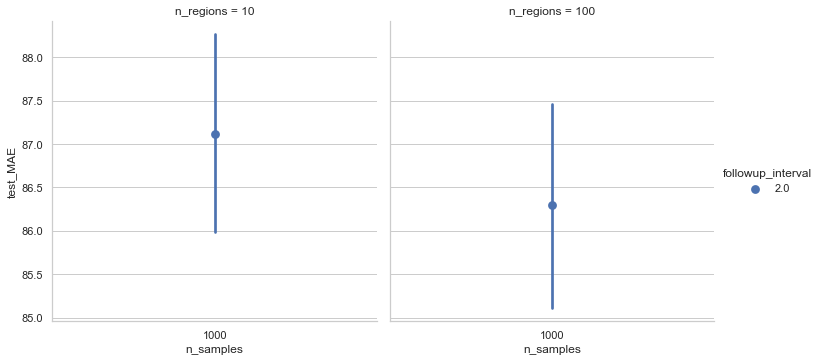

In [31]:
palette = 'husl'
sns.set(font_scale=1)

plot_df = perf_df.copy()
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="followup_interval",col="n_regions", kind="point", data=plot_df, aspect=1)


## Plots

Perf for model: RandomForestRegressor(n_jobs=4, random_state=1)


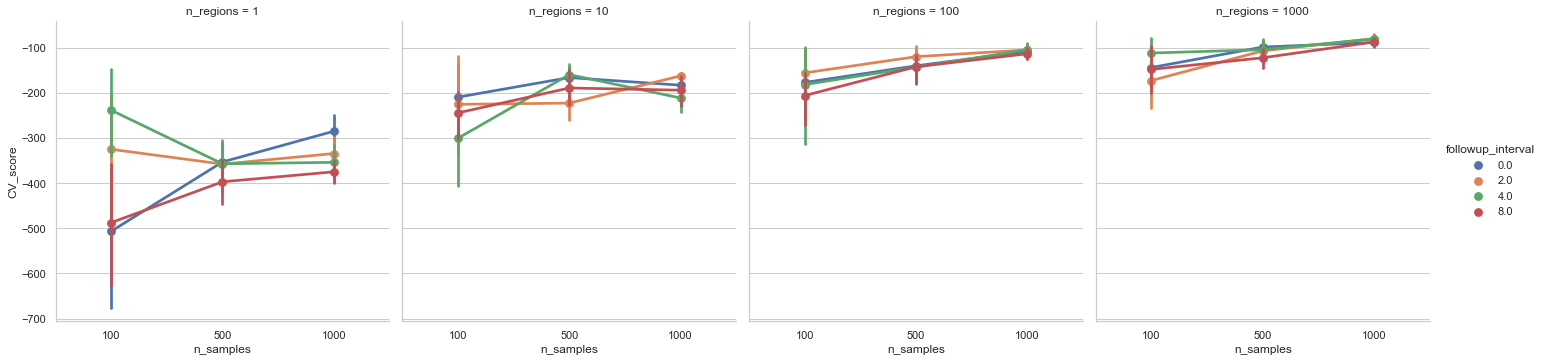

In [18]:
palette = 'husl'
sns.set(font_scale=1)

my_model = perf_df["model"].unique()[1]
print(f"Perf for model: {my_model}")
plot_df = perf_df[perf_df["model"]==my_model].copy()
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="CV_score",x="n_samples",hue="followup_interval",col="n_regions", kind="point", data=plot_df, aspect=1)



Perf for model: RandomForestRegressor(n_jobs=4, random_state=1)


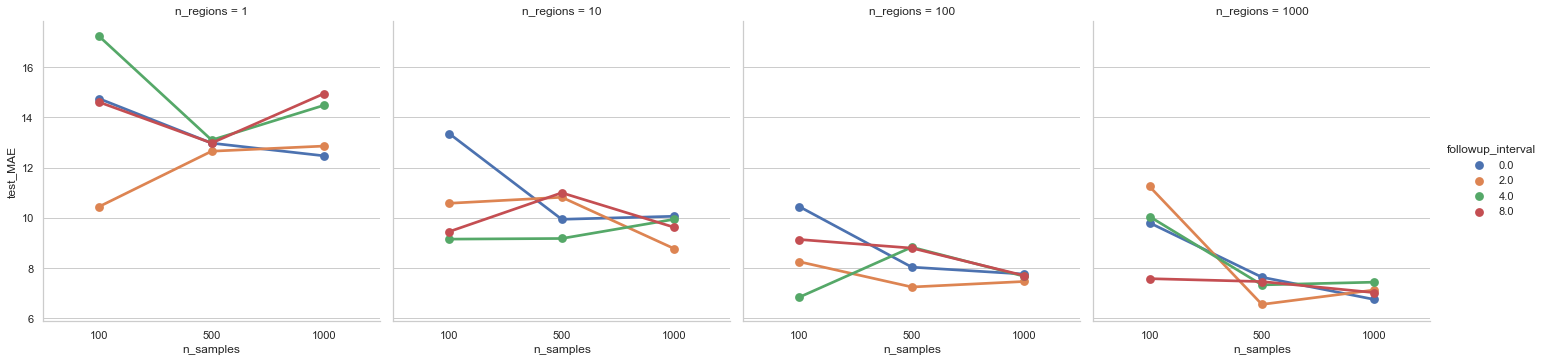

In [19]:
print(f"Perf for model: {my_model}")
plot_df = perf_df[perf_df["model"]==my_model].copy()

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",col="n_regions",hue="followup_interval", kind="point", data=plot_df, aspect=1)